## Random forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load dataset
df = pd.read_csv('C:\\Users\\srikar kulkarni\\OneDrive\\Desktop\\EDA\\finalcleaned_scaled.csv')

# Drop irrelevant and missing values
df = df.drop(columns=["State Name", "Dist Name"]).dropna()

# Define binary target labels
df['Low_Yield'] = (df['RICE YIELD (Kg per ha)'] < df['RICE YIELD (Kg per ha)'].median()).astype(int)
df['High_Production'] = (df['RICE PRODUCTION (1000 tons)'] > df['RICE PRODUCTION (1000 tons)'].median()).astype(int)
df['Large_Area'] = (df['RICE AREA (1000 ha)'] > df['RICE AREA (1000 ha)'].median()).astype(int)

# Feature set
X = df.drop(columns=[
    'RICE YIELD (Kg per ha)', 
    'RICE PRODUCTION (1000 tons)', 
    'RICE AREA (1000 ha)', 
    'Low_Yield', 
    'High_Production', 
    'Large_Area'
])
Y = df[['Low_Yield', 'High_Production', 'Large_Area']]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Random Forest inside MultiOutputClassifier
rf_model = make_pipeline(
    StandardScaler(),
    MultiOutputClassifier(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
)

# Train the model
rf_model.fit(X_train, Y_train)

# Predict
rf_predictions = rf_model.predict(X_test)

# Store predictions in a DataFrame
rf_results = pd.DataFrame(
    rf_predictions,
    columns=["Low_Yield_Pred", "High_Production_Pred", "Large_Area_Pred"]
)

# Add sample identifier
rf_results.insert(0, "Sample_ID", X_test.index)
rf_results.set_index("Sample_ID", inplace=True)

# Summary
print(rf_results.describe())

# Merge the two result DataFrames on their index (Sample_ID)
combined_results = rf_results.copy()
combined_results.reset_index(inplace=True)
combined_results.to_csv("C:\\Users\\srikar kulkarni\\OneDrive\\Desktop\\EDA\\rf_model_predictions.csv", index=False)


# Optional: Reset index to make Sample_ID a column
combined_results.reset_index(inplace=True)

# Save to CSV
combined_results.to_csv("C:\\Users\\srikar kulkarni\\OneDrive\\Desktop\\EDA\\combined_model_predictions.csv", index=False)


       Low_Yield_Pred  High_Production_Pred  Large_Area_Pred
count     2177.000000           2177.000000      2177.000000
mean         0.507579              0.491043         0.500230
std          0.500057              0.500035         0.500115
min          0.000000              0.000000         0.000000
25%          0.000000              0.000000         0.000000
50%          1.000000              0.000000         1.000000
75%          1.000000              1.000000         1.000000
max          1.000000              1.000000         1.000000


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate each target separately
for i, col in enumerate(Y.columns):
    print(f"\n--- Performance for '{col}' ---")
    acc = accuracy_score(Y_test.iloc[:, i], rf_predictions[:, i])
    prec = precision_score(Y_test.iloc[:, i], rf_predictions[:, i])
    rec = recall_score(Y_test.iloc[:, i], rf_predictions[:, i])
    f1 = f1_score(Y_test.iloc[:, i], rf_predictions[:, i])
    
    print(f"Accuracy  : {acc * 100:.2f}%")
    print(f"Precision : {prec * 100:.2f}%")
    print(f"Recall    : {rec * 100:.2f}%")
    print(f"F1 Score  : {f1 * 100:.2f}%")



--- Performance for 'Low_Yield' ---
Accuracy  : 85.53%
Precision : 82.44%
Recall    : 88.28%
F1 Score  : 85.26%

--- Performance for 'High_Production' ---
Accuracy  : 89.62%
Precision : 87.65%
Recall    : 90.88%
F1 Score  : 89.24%

--- Performance for 'Large_Area' ---
Accuracy  : 95.64%
Precision : 95.41%
Recall    : 95.85%
F1 Score  : 95.63%


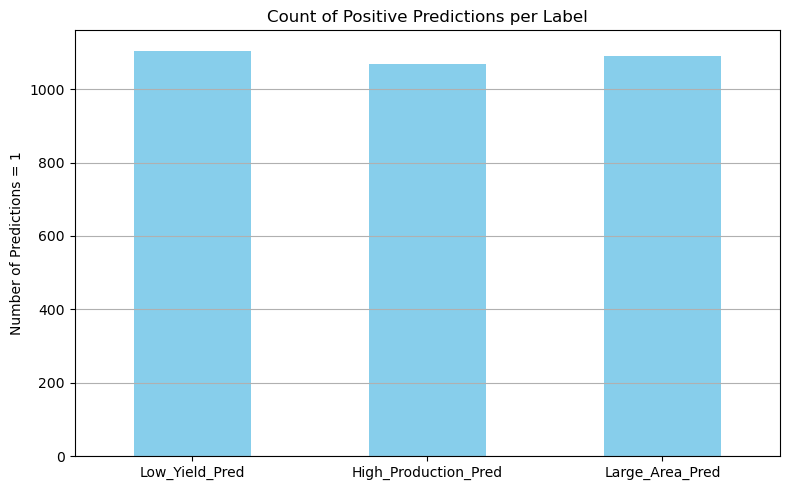

In [6]:
import matplotlib.pyplot as plt

# Count predictions for each label
label_counts = rf_results.sum()

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Positive Predictions per Label')
plt.ylabel('Number of Predictions = 1')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


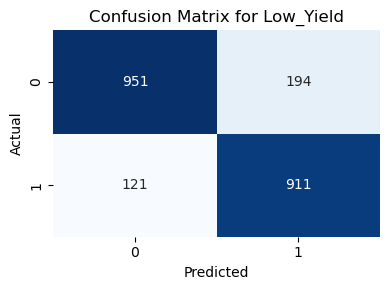

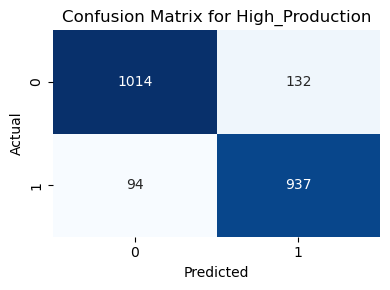

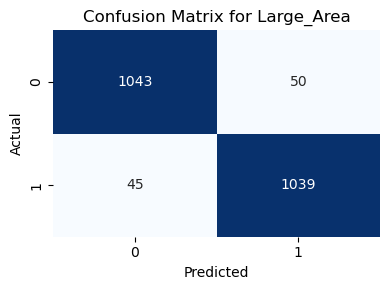

In [7]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Get actual vs predicted
y_true = Y_test.reset_index(drop=True)
y_pred = pd.DataFrame(rf_predictions, columns=Y.columns)

# Confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plot each confusion matrix as heatmap
for i, label in enumerate(Y.columns):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


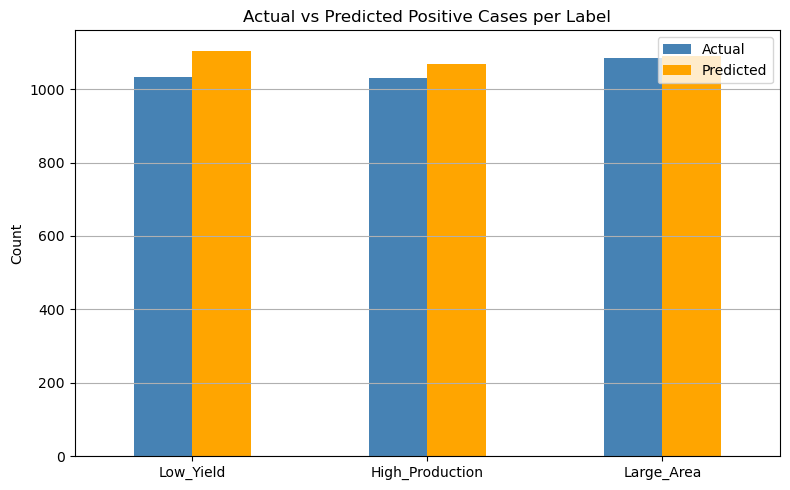

In [8]:
# Count actual vs predicted for each label
actual_counts = y_true.sum()
pred_counts = y_pred.sum()

df_compare = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': pred_counts
})

df_compare.plot(kind='bar', stacked=False, figsize=(8, 5), color=['steelblue', 'orange'])
plt.title('Actual vs Predicted Positive Cases per Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


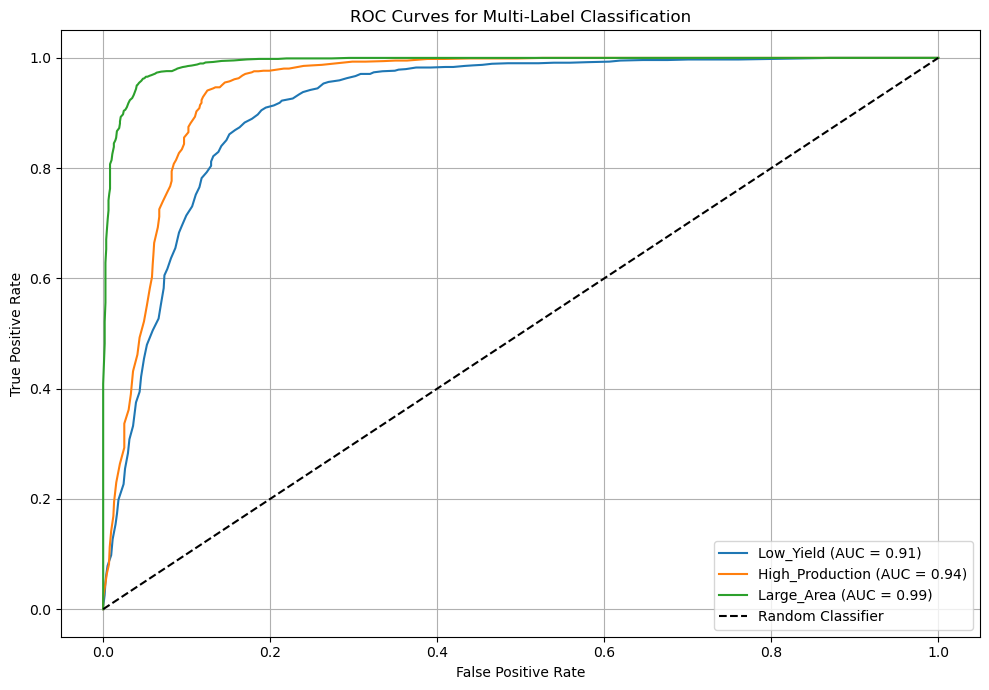

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = rf_model.predict_proba(X_test)

# Plot ROC for each label
plt.figure(figsize=(10, 7))

for i, label in enumerate(Y.columns):
    # `predict_proba` returns a list of arrays for each label
    fpr, tpr, _ = roc_curve(Y_test.iloc[:, i], y_prob[i][:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('ROC Curves for Multi-Label Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


C:\Users\srikar kulkarni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srikar kulkarni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srikar kulkarni\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


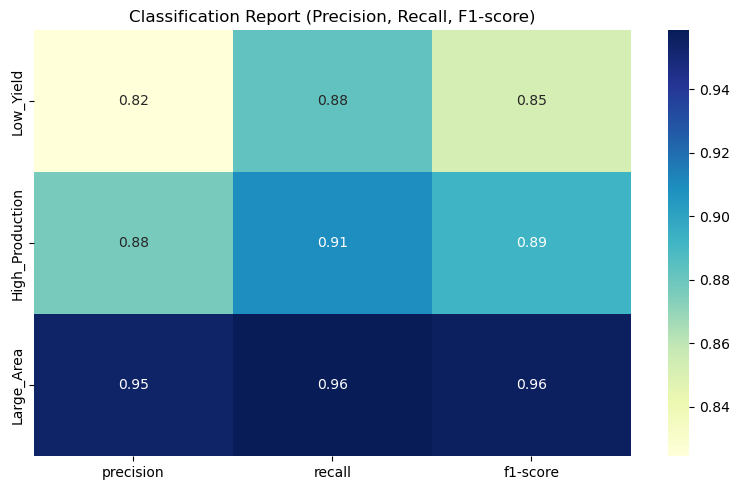

In [10]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# Get classification report
report = classification_report(Y_test, rf_predictions, target_names=Y.columns, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Drop support column for clearer heatmap
report_df_no_support = report_df.drop(columns=['support'])

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(report_df_no_support.iloc[:3], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Classification Report (Precision, Recall, F1-score)')
plt.tight_layout()
plt.show()


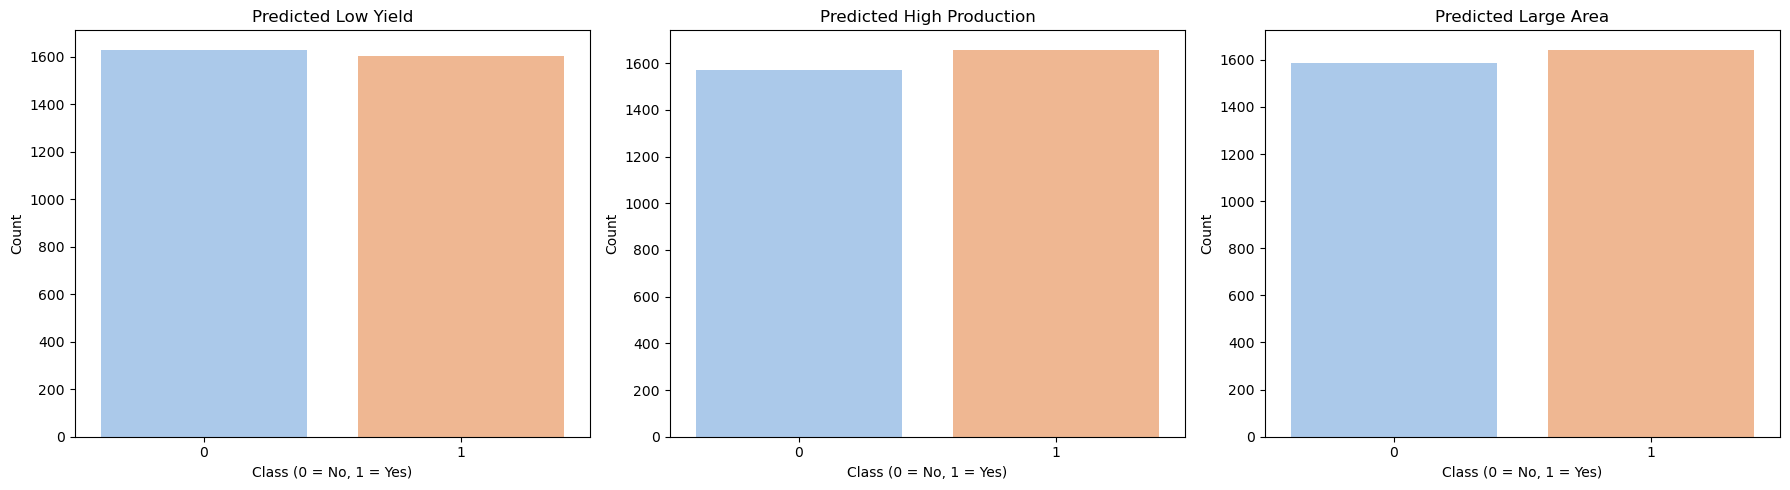

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

target_names = ["Low_Yield_Pred", "High_Production_Pred", "Large_Area_Pred"]
titles = ["Predicted Low Yield", "Predicted High Production", "Predicted Large Area"]

for i, ax in enumerate(axs):
    sns.countplot(data=rf_results, x=target_names[i], hue=target_names[i], ax=ax, palette="pastel", legend=False)
    ax.set_title(titles[i])
    ax.set_xlabel("Class (0 = No, 1 = Yes)")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit unweighted
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nUnweighted Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# Weighted version
sample_weights = np.where(y_train > y_train.median(), 2.0, 1.0)
model_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
model_weighted.fit(X_train, y_train, regressor__sample_weight=sample_weights)
y_pred_weighted = model_weighted.predict(X_test)

print("\nWeighted Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred_weighted))
print("R²:", r2_score(y_test, y_pred_weighted))



Unweighted Random Forest:
MSE: 249632.81505015926
R²: 0.7267499010219822
